In [1]:
import pandas as pd
from Bio.SeqUtils import IsoelectricPoint
import re
from collections import Counter
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind
import matplotlib.colors as mcolors
from matplotlib_venn import venn3
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import itertools

plt.rcParams["svg.fonttype"] = "none"

**HCR-PROXY DEFINED PROTEINS**

**Import the mouse proteome from Uniprot**

In [2]:
uniprot_data_all = pd.read_csv('data/uniprot_data/uniprotkb_taxonomy_id_10090_2025_03_25.tsv', sep='\t')
uniprot_data_all

/tmp/ipykernel_2484452/2471962900.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  uniprot_data_all = pd.read_csv('/ceph/hpc/home/novljanj/data_storage/projects/nucleolus_enriched_proteins/data/uniprot_data/uniprotkb_taxonomy_id_10090_2025_03_25.tsv', sep='\t')


,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Compositional bias,Mass,Sequence,...,Redox potential,Region,Ensembl,Coiled coil,Domain [CC],Domain [FT],Motif,Repeat,Zinc finger,Gene Ontology (cellular component)
0,A0A075F5C6,unreviewed,A0A075F5C6_MOUSE,Heat shock factor 1 (Heat shock transcription ...,Hsf1,Mus musculus (Mouse),531,"COMPBIAS 343..355; /note=""Polar residues""; /ev...",57879,MDLAVGPGAAGPSNVPAFLTKLWTLVSDPDTDALICWSPSGNSFHV...,...,NaN,"REGION 272..327; /note=""Disordered""; /evidence...",ENSMUST00000228371.2;,NaN,NaN,"DOMAIN 57..81; /note=""HSF-type DNA-binding""; /...",NaN,NaN,NaN,centrosome [GO:0005813]; cytosol [GO:0005829];...
1,A0A087WPF7,reviewed,AUTS2_MOUSE,Autism susceptibility gene 2 protein homolog,Auts2 Kiaa0442,Mus musculus (Mouse),1261,"COMPBIAS 8..17; /note=""Basic residues""; /evide...",138920,MDGPTRGHGLRKKRRSRSQRDRERRSRAGLGTGAAGGIGAGRTRAP...,...,NaN,"REGION 1..88; /note=""Disordered""; /evidence=""E...",ENSMUST00000161226.11 [A0A087WPF7-1];ENSMUST00...,NaN,DOMAIN: The Pro-rich region is important for t...,NaN,NaN,NaN,NaN,cytoplasm [GO:0005737]; cytoskeleton [GO:00058...
2,A0A087WPT2,unreviewed,A0A087WPT2_MOUSE,Prostaglandin-endoperoxide synthase 2,Ptgs2,Mus musculus (Mouse),62,NaN,7199,MSTGFDQYKCDCTRTGFYGENCTTPEFLTRIKLLLKPTPNTVHYIL...,...,NaN,NaN,ENSMUST00000190784.2;,NaN,NaN,"DOMAIN 1..23; /note=""EGF-like""; /evidence=""ECO...",NaN,NaN,NaN,NaN
3,A0A087WRK1,unreviewed,A0A087WRK1_MOUSE,"Predicted gene, 20814 (Predicted gene, 20855) ...",Gm20905 Gm20814 Gm20835 Gm20850 Gm20855 Gm2086...,Mus musculus (Mouse),222,NaN,25620,MRRMALKKLKVIPKEGYLLLLDFDDEDDDIKVSEEALSEVKSPAFD...,...,NaN,"REGION 39..64; /note=""Disordered""; /evidence=""...",ENSMUST00000185240.2;ENSMUST00000185245.2;ENSM...,NaN,NaN,"DOMAIN 112..220; /note=""XLR/SYCP3/FAM9""; /evid...",NaN,NaN,NaN,cytoplasm [GO:0005737]; nucleus [GO:0005634]
4,A0A087WRT4,unreviewed,A0A087WRT4_MOUSE,FAT atypical cadherin 1,Fat1,Mus musculus (Mouse),4602,"COMPBIAS 4258..4267; /note=""Polar residues""; /...",507531,MGRHLTLLLLLLLFLQQFGDSDGSQRLEPTPPIQFTHFQYNVTVHE...,...,NaN,"REGION 4256..4292; /note=""Disordered""; /eviden...",ENSMUST00000189017.8;,NaN,NaN,"DOMAIN 36..150; /note=""Cadherin""; /evidence=""E...",NaN,NaN,NaN,apical plasma membrane [GO:0016324]; cell junc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87487,Z4YN82,unreviewed,Z4YN82_MOUSE,Syntaphilin,Snph,Mus musculus (Mouse),87,NaN,9364,MAMSLQGSRRASAGSRRRTSPPVSVRDAYGTSSLSSSSNSGSCKGS...,...,NaN,"REGION 1..74; /note=""Disordered""; /evidence=""E...",ENSMUST00000137936.2;,NaN,NaN,NaN,NaN,NaN,NaN,membrane [GO:0016020]
87488,Z4YN86,unreviewed,Z4YN86_MOUSE,Translocase of inner mitochondrial membrane 22,Timm22,Mus musculus (Mouse),116,NaN,12689,MAATAPKAGGSAPEAAGSAEAPLQYSLLLQYLVGDKRQPRLLEPGS...,...,NaN,NaN,ENSMUST00000152183.2;,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87489,Z4YN92,unreviewed,Z4YN92_MOUSE,A kinase anchor protein 17B,Akap17b,Mus musculus (Mouse),406,"COMPBIAS 24..52; /note=""Basic and acidic resid...",47765,MFDTTKHFSEGAIQRRNQERLKLQELEEERKKEKKREEEVAERKRK...,...,NaN,"REGION 24..90; /note=""Disordered""; /evidence=""...",ENSMUST00000133980.2;,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87490,Z4YN97,unreviewed,Z4YN97_MOUSE,Adenylate kinase 1,Ak1,Mus musculus (Mouse),89,NaN,9541,MEEKLKKAKIIFVVGGPGSGKGTQCEKIVQKYGYTHLSTGDLLRAE...,...,NaN,NaN,ENSMUST00000156578.8;,NaN,NaN,NaN,NaN,NaN,NaN,cytoplasm [GO:0005737]


**Select the enriched proteins in each nucleolar compartments based on p-value cutoff**

In [3]:
proteome_data = pd.read_excel("data/proteome_data/Df.res_Nucleolar dataset_20250210.xlsx")

S45_genes = set(proteome_data[(proteome_data["lab5_S45.min.p"] < 0.05) & (proteome_data["lab5_S45.min"] > 0.0)]["Majority.protein.IDs"].tolist())
ITS2_genes = set(proteome_data[(proteome_data["lab5_ITS2.min.p"] < 0.05) & (proteome_data["lab5_ITS2.min"] > 0.0)]["Majority.protein.IDs"].tolist())

print("S45_genes:   ", len(S45_genes))
print("ITS2_genes:  ", len(ITS2_genes))

S47_genes_vs_S45 = set(proteome_data[(proteome_data["lab5_S45.min.p"] < 0.05) & (proteome_data["lab5_S45.min"] < 0.0)]["Majority.protein.IDs"].tolist())
S47_genes_vs_ITS2  = set(proteome_data[(proteome_data["lab5_ITS2.min.p"] < 0.05) & (proteome_data["lab5_ITS2.min"] < 0.0)]["Majority.protein.IDs"].tolist())

print("S47_genes_vs_S45: ", len(S47_genes_vs_S45))
print("S47_genes_vs_ITS2: ", len(S47_genes_vs_ITS2))

S47_genes = S47_genes_vs_S45.intersection(S47_genes_vs_ITS2)
print("S47_genes via intersection:   ", len(S47_genes))

S45_genes:    84
ITS2_genes:   75
S47_genes_vs_S45:  182
S47_genes_vs_ITS2:  393
S47_genes via intersection:    118


**Venn diagram of the compartments**

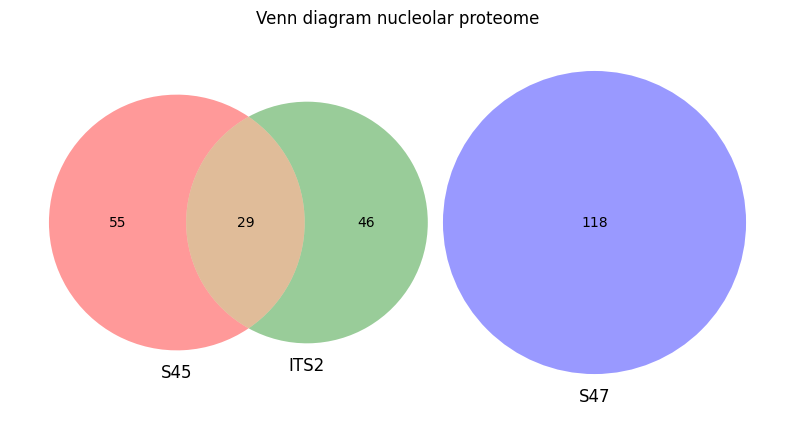

In [4]:
def venn3_plotting(sets, labels, name=None):

    plt.figure(figsize=(10, 7))
    venn3(sets, labels)
    plt.title(name)
    plt.show()

venn3_plotting([S45_genes, ITS2_genes, S47_genes], ['S45', 'ITS2', 'S47'], name="Venn diagram nucleolar proteome")


**Parsing composition and disorder from UniProt**

In [5]:
def extract_domain_notes(domain_str):
    if pd.isna(domain_str):
        return None

    notes = re.findall(r'/note="(.*?)"', domain_str)
    return notes if notes else None

def parse_disordered_regions(region_str):
    """Extract start-end ranges of disordered regions from the Region string."""
    if not isinstance(region_str, str):
        return []
    matches = re.findall(r'REGION (\d+)\.\.(\d+); /note="Disordered"', region_str)
    return [(int(start), int(end)) for start, end in matches]

def calculate_aa_composition(sequence):
    """Calculate amino acid composition as a percentage."""
    total = len(sequence)
    counts = Counter(sequence)
    return {aa: counts[aa] / total for aa in 'ACDEFGHIKLMNPQRSTVWY'}

def analyze_disorder(row):
    regions = parse_disordered_regions(row['Region'])
    full_seq = row['Sequence']
    total_len = len(full_seq)

    aa_compositions = []
    disordered_len = 0

    for start, end in regions:
        region_seq = full_seq[start-1:end]
        disordered_len += len(region_seq)
        aa_compositions.append(calculate_aa_composition(region_seq))

    if aa_compositions:
        avg_composition = {
            aa: sum(comp.get(aa, 0) for comp in aa_compositions) / len(aa_compositions)
            for aa in 'ACDEFGHIKLMNPQRSTVWY'
        }
    else:
        avg_composition = {aa: 0 for aa in 'ACDEFGHIKLMNPQRSTVWY'}

    disordered_indices = set()
    for start, end in regions:
        disordered_indices.update(range(start-1, end))
    ordered_indices = [i for i in range(total_len) if i not in disordered_indices]
    ordered_seq = ''.join(full_seq[i] for i in ordered_indices)
    if ordered_seq:
        non_disordered_composition = calculate_aa_composition(ordered_seq)
    else:
        non_disordered_composition = {aa: 0 for aa in 'ACDEFGHIKLMNPQRSTVWY'}

    return pd.Series({
        'Disorder_percent': disordered_len / total_len,
        'Num_disordered_regions': len(regions),
        'Disordered_AA_avg': ','.join(f'{aa}:{avg_composition[aa]:.2f}' for aa in 'ACDEFGHIKLMNPQRSTVWY'),
        'NonDisordered_AA_avg': ','.join(f'{aa}:{non_disordered_composition[aa]:.2f}' for aa in 'ACDEFGHIKLMNPQRSTVWY')
    })

uniprot_data_all["Parsed_Domains"] = uniprot_data_all["Domain [FT]"].apply(extract_domain_notes)
uniprot_data_all[['Disorder_percent', 'Num_disordered_regions', 'Disordered_AA_avg', 'NonDisordered_AA_avg']] = uniprot_data_all.apply(analyze_disorder, axis=1)

uniprot_data_all


,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Compositional bias,Mass,Sequence,...,Domain [FT],Motif,Repeat,Zinc finger,Gene Ontology (cellular component),Parsed_Domains,Disorder_percent,Num_disordered_regions,Disordered_AA_avg,NonDisordered_AA_avg
0,A0A075F5C6,unreviewed,A0A075F5C6_MOUSE,Heat shock factor 1 (Heat shock transcription ...,Hsf1,Mus musculus (Mouse),531,"COMPBIAS 343..355; /note=""Polar residues""; /ev...",57879,MDLAVGPGAAGPSNVPAFLTKLWTLVSDPDTDALICWSPSGNSFHV...,...,"DOMAIN 57..81; /note=""HSF-type DNA-binding""; /...",NaN,NaN,NaN,centrosome [GO:0005813]; cytosol [GO:0005829];...,[HSF-type DNA-binding],0.209040,3,"A:0.11,C:0.00,D:0.08,E:0.04,F:0.01,G:0.05,H:0....","A:0.06,C:0.01,D:0.06,E:0.06,F:0.04,G:0.05,H:0...."
1,A0A087WPF7,reviewed,AUTS2_MOUSE,Autism susceptibility gene 2 protein homolog,Auts2 Kiaa0442,Mus musculus (Mouse),1261,"COMPBIAS 8..17; /note=""Basic residues""; /evide...",138920,MDGPTRGHGLRKKRRSRSQRDRERRSRAGLGTGAAGGIGAGRTRAP...,...,NaN,NaN,NaN,NaN,cytoplasm [GO:0005737]; cytoskeleton [GO:00058...,None,0.665345,7,"A:0.07,C:0.00,D:0.05,E:0.06,F:0.02,G:0.06,H:0....","A:0.06,C:0.00,D:0.06,E:0.03,F:0.06,G:0.07,H:0...."
2,A0A087WPT2,unreviewed,A0A087WPT2_MOUSE,Prostaglandin-endoperoxide synthase 2,Ptgs2,Mus musculus (Mouse),62,NaN,7199,MSTGFDQYKCDCTRTGFYGENCTTPEFLTRIKLLLKPTPNTVHYIL...,...,"DOMAIN 1..23; /note=""EGF-like""; /evidence=""ECO...",NaN,NaN,NaN,NaN,[EGF-like],0.000000,0,"A:0.00,C:0.00,D:0.00,E:0.00,F:0.00,G:0.00,H:0....","A:0.00,C:0.05,D:0.03,E:0.03,F:0.08,G:0.06,H:0...."
3,A0A087WRK1,unreviewed,A0A087WRK1_MOUSE,"Predicted gene, 20814 (Predicted gene, 20855) ...",Gm20905 Gm20814 Gm20835 Gm20850 Gm20855 Gm2086...,Mus musculus (Mouse),222,NaN,25620,MRRMALKKLKVIPKEGYLLLLDFDDEDDDIKVSEEALSEVKSPAFD...,...,"DOMAIN 112..220; /note=""XLR/SYCP3/FAM9""; /evid...",NaN,NaN,NaN,cytoplasm [GO:0005737]; nucleus [GO:0005634],[XLR/SYCP3/FAM9],0.117117,1,"A:0.12,C:0.00,D:0.15,E:0.19,F:0.04,G:0.04,H:0....","A:0.03,C:0.02,D:0.08,E:0.11,F:0.03,G:0.04,H:0...."
4,A0A087WRT4,unreviewed,A0A087WRT4_MOUSE,FAT atypical cadherin 1,Fat1,Mus musculus (Mouse),4602,"COMPBIAS 4258..4267; /note=""Polar residues""; /...",507531,MGRHLTLLLLLLLFLQQFGDSDGSQRLEPTPPIQFTHFQYNVTVHE...,...,"DOMAIN 36..150; /note=""Cadherin""; /evidence=""E...",NaN,NaN,NaN,apical plasma membrane [GO:0016324]; cell junc...,"[Cadherin, Cadherin, Cadherin, Cadherin, Cadhe...",0.050847,6,"A:0.04,C:0.01,D:0.08,E:0.10,F:0.03,G:0.05,H:0....","A:0.06,C:0.01,D:0.07,E:0.07,F:0.04,G:0.06,H:0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87487,Z4YN82,unreviewed,Z4YN82_MOUSE,Syntaphilin,Snph,Mus musculus (Mouse),87,NaN,9364,MAMSLQGSRRASAGSRRRTSPPVSVRDAYGTSSLSSSSNSGSCKGS...,...,NaN,NaN,NaN,NaN,membrane [GO:0016020],None,0.850575,1,"A:0.05,C:0.03,D:0.04,E:0.01,F:0.00,G:0.08,H:0....","A:0.00,C:0.08,D:0.00,E:0.08,F:0.00,G:0.00,H:0...."
87488,Z4YN86,unreviewed,Z4YN86_MOUSE,Translocase of inner mitochondrial membrane 22,Timm22,Mus musculus (Mouse),116,NaN,12689,MAATAPKAGGSAPEAAGSAEAPLQYSLLLQYLVGDKRQPRLLEPGS...,...,NaN,NaN,NaN,NaN,NaN,None,0.000000,0,"A:0.00,C:0.00,D:0.00,E:0.00,F:0.00,G:0.00,H:0....","A:0.12,C:0.02,D:0.01,E:0.08,F:0.01,G:0.10,H:0...."
87489,Z4YN92,unreviewed,Z4YN92_MOUSE,A kinase anchor protein 17B,Akap17b,Mus musculus (Mouse),406,"COMPBIAS 24..52; /note=""Basic and acidic resid...",47765,MFDTTKHFSEGAIQRRNQERLKLQELEEERKKEKKREEEVAERKRK...,...,NaN,NaN,NaN,NaN,NaN,None,0.334975,3,"A:0.10,C:0.01,D:0.04,E:0.13,F:0.00,G:0.01,H:0....","A:0.04,C:0.02,D:0.05,E:0.10,F:0.02,G:0.05,H:0...."
87490,Z4YN97,unreviewed,Z4YN97_MOUSE,Adenylate kinase 1,Ak1,Mus musculus (Mouse),89,NaN,9541,MEEKLKKAKIIFVVGGPGSGKGTQCEKIVQKYGYTHLSTGDLLRAE...,...,NaN,NaN,NaN,NaN,cytoplasm [GO:0005737],None,0.000000,0,"A:0.00,C:0.00,D:0.00,E:0.00,F:0.00,G:0.00,H:0....","A:0.06,C:0.01,D:0.06,E:0.08,F:0.01,G:0.12,H:0...."


**Clean up the dataframe and format**

In [6]:
rows = []

lists = [S45_genes, S47_genes, ITS2_genes]
names = ["S45", "S47", "ITS2"]

for i, l in enumerate(lists):
    for gene in l:
        if ";" in gene:
            gene_sep = gene.split(";")
            for g in gene_sep:
                if g not in uniprot_data_all["Entry"].values:
                    print(f"{g} not in uniprot data")
                    continue

                rows.append({
                    "Majority.protein.IDs": gene,
                    "Reviewed": uniprot_data_all[uniprot_data_all["Entry"] == g]["Reviewed"].values[0],
                    "Protein ID": g,
                    "Sequence": uniprot_data_all[uniprot_data_all["Entry"] == g]["Sequence"].values[0],
                    "Label": names[i],
                    "Parsed_Domains" : uniprot_data_all[uniprot_data_all["Entry"] == g]["Parsed_Domains"].values[0],
                    "Disorder_percent": uniprot_data_all[uniprot_data_all["Entry"] == g]["Disorder_percent"].values[0],
                    "Num_disordered_regions": uniprot_data_all[uniprot_data_all["Entry"] == g]["Num_disordered_regions"].values[0],
                })
        else:
            g = gene
            if g not in uniprot_data_all["Entry"].values:
                print(f"{g} not in uniprot data")
                continue
            seq = uniprot_data_all[uniprot_data_all["Entry"] == g]["Sequence"].values[0]
            reviewed = uniprot_data_all[uniprot_data_all["Entry"] == g]["Reviewed"].values[0]
            rows.append({
                "Majority.protein.IDs": gene,
                "Reviewed": uniprot_data_all[uniprot_data_all["Entry"] == g]["Reviewed"].values[0],
                "Protein ID": g,
                "Sequence": uniprot_data_all[uniprot_data_all["Entry"] == g]["Sequence"].values[0],
                "Label": names[i],
                "Parsed_Domains" : uniprot_data_all[uniprot_data_all["Entry"] == g]["Parsed_Domains"].values[0],
                "Disorder_percent": uniprot_data_all[uniprot_data_all["Entry"] == g]["Disorder_percent"].values[0],
                "Num_disordered_regions": uniprot_data_all[uniprot_data_all["Entry"] == g]["Num_disordered_regions"].values[0],
            })

cleaned_data = pd.DataFrame(rows)
cleaned_data

A0A2I3BPG9 not in uniprot data
P49945 not in uniprot data


,Majority.protein.IDs,Reviewed,Protein ID,Sequence,Label,Parsed_Domains,Disorder_percent,Num_disordered_regions
0,Q64525;Q6ZWY9;Q64478;P10854,reviewed,Q64525,MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRKESYSVYVYKVL...,S45,None,0.285714,1
1,Q64525;Q6ZWY9;Q64478;P10854,reviewed,Q6ZWY9,MPEPAKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVL...,S45,None,0.285714,1
2,Q64525;Q6ZWY9;Q64478;P10854,reviewed,Q64478,MPEPAKSAPAPKKGSKKALTKAQKKDGKKRKRSRKESYSVYVYKVL...,S45,None,0.285714,1
3,Q64525;Q6ZWY9;Q64478;P10854,reviewed,P10854,MPEPTKSAPAPKKGSKKAVTKAQKKDGKKRKRSRKESYSVYVYKVL...,S45,None,0.285714,1
4,Q9CU62,reviewed,Q9CU62,MGFLKLIEIENFKSYKGRQIIGPFQRFTAIIGPNGSGKSNLMDAIS...,S45,[SMC hinge],0.056772,3
...,...,...,...,...,...,...,...,...
302,Q8CGP4;C0HKE9;C0HKE8;C0HKE7;C0HKE6;C0HKE5;C0HK...,reviewed,Q8CGP7,MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGA...,ITS2,None,0.169231,1
303,Q8CGP4;C0HKE9;C0HKE8;C0HKE7;C0HKE6;C0HKE5;C0HK...,reviewed,Q8CGP5,MSGRGKQGGKARAKAKTRSSRAGLQFPVGRVHRLLRKGNYSERVGA...,ITS2,None,0.169231,1
304,Q8CGP4;C0HKE9;C0HKE8;C0HKE7;C0HKE6;C0HKE5;C0HK...,reviewed,Q8BFU2,MSGRGKQGGKARAKAKSRSSRAGLQFPVGRVHRLLRKGNYSERVGA...,ITS2,None,0.169231,1
305,P27661,reviewed,P27661,MSGRGKTGGKARAKAKSRSSRAGLQFPVGRVHRLLRKGHYAERVGA...,ITS2,None,0.314685,2


**Only select the review-ed or longest protein per Majority.protein.IDs**

In [7]:
cleaned_data["SeqLength"] = cleaned_data["Sequence"].apply(len)

final_rows = []

for protein_group, group_df in cleaned_data.groupby(["Majority.protein.IDs", "Label"]):
    reviewed_df = group_df[group_df["Reviewed"] == "reviewed"]

    if len(reviewed_df) == 1:
        final_rows.append(reviewed_df.iloc[0])

    elif len(reviewed_df) > 1:
        reviewed_df["SeqLength"] = reviewed_df["Sequence"].apply(len)
        longest = reviewed_df.sort_values("SeqLength", ascending=False).iloc[0]
        final_rows.append(longest)

    else:
        group_df["SeqLength"] = group_df["Sequence"].apply(len)
        longest = group_df.sort_values("SeqLength", ascending=False).iloc[0]
        final_rows.append(longest)

final_df = pd.DataFrame(final_rows).drop(columns=["SeqLength"]).reset_index(drop=True)
final_df["Length"] = final_df["Sequence"].apply(len)
sorted_df = final_df.sort_values("Length", ascending=False)
sorted_df["Label"].value_counts()
sorted_df

/tmp/ipykernel_2484452/4101237575.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviewed_df["SeqLength"] = reviewed_df["Sequence"].apply(len)


,Majority.protein.IDs,Reviewed,Protein ID,Sequence,Label,Parsed_Domains,Disorder_percent,Num_disordered_regions,Length
25,P08775,reviewed,P08775,MHGGGPPSGDSACPLRTIKRVQFGVLSPDELKRMSVTEGGIKYPET...,S47,None,0.215736,1,1970
20,P02468,reviewed,P02468,MTGGGRAALALQPRGRLWPLLAVLAAVAGCVRAAMDECADEGGRPQ...,S47,"[Laminin N-terminal, Laminin EGF-like 1, Lamin...",0.000000,0,1607
18,O88322,reviewed,O88322,MFRDPTAGWLTPPSPLSLLVMLLLLSRVGALRPDELFPYGESWGDQ...,S47,"[NIDO, EGF-like 1, Nidogen G2 beta-barrel, EGF...",0.074127,2,1403
41,P23116,reviewed,P23116,MPAYFQRPENALKRANEFLEVGKKQPALDVLYDVMKSKKHRTWQKI...,S47,[PCI],0.376488,3,1344
233,Q9CU62,reviewed,Q9CU62,MGFLKLIEIENFKSYKGRQIIGPFQRFTAIIGPNGSGKSNLMDAIS...,S45,[SMC hinge],0.056772,3,1233
...,...,...,...,...,...,...,...,...,...
215,Q99LT0,reviewed,Q99LT0,MESEQMLEGQTQVAENPHSEYGLTDSVERIVENEKINAEKSSKQKV...,S45,None,0.262626,1,99
15,O35900,reviewed,O35900,MLFYSFFKSLVGKDVVVELKNDLSICGTLHSVDQYLNIKLTDISVT...,ITS2,[Sm],0.000000,0,95
79,P61514,reviewed,P61514,MAKRTKKVGIVGKYGTRYGASLRKMVKKIEISQHAKYTCSFCGKTK...,S45,None,0.000000,0,92
17,O54962,reviewed,O54962,MTTSQKHRDFVAEPMGEKPVGSLAGIGDVLSKRLEERGFDKAYVVL...,ITS2,[HhH],0.000000,0,89


**Add all nuclear proteins from UniProt as control set excluding the ones in compartments**

In [8]:
nuclear_proteome_data = pd.read_csv('data/uniprot_data/uniprotkb_taxonomy_id_10090_AND_go_0005_2025_03_25.tsv', sep='\t')
print(nuclear_proteome_data.shape)
nuclear_proteome_data = nuclear_proteome_data[nuclear_proteome_data["Reviewed"] == "reviewed"].reset_index(drop=True)
nuclear_proteome_data = uniprot_data_all[uniprot_data_all["Entry"].isin(nuclear_proteome_data["Entry"])]
print(nuclear_proteome_data.shape)

nuclear_proteome_data= nuclear_proteome_data[~nuclear_proteome_data["Entry"].isin(sorted_df["Protein ID"])]
print(nuclear_proteome_data.shape)

data_all_prots = pd.concat([sorted_df, nuclear_proteome_data], ignore_index=True)
print(nuclear_proteome_data.shape)

data_all_prots["Label"].fillna("All Nuclear Proteins", inplace=True)
data_all_prots["Length"] = data_all_prots["Sequence"].apply(len)
print(data_all_prots.shape)
data_all_prots['Sequence'] = data_all_prots['Sequence'].astype(str)
data_all_prots["Label"].value_counts()

(15776, 21)
(6024, 26)
(5858, 26)
(5858, 26)
(6135, 29)


/tmp/ipykernel_2484452/1058298403.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_all_prots["Label"].fillna("All Nuclear Proteins", inplace=True)


Label
All Nuclear Proteins    5858
S47                      118
S45                       84
ITS2                      75
Name: count, dtype: int64

**Calculate the difference in means between control and each compartment and plotting with radarplot with bootstrapping for CI of the diff in means**

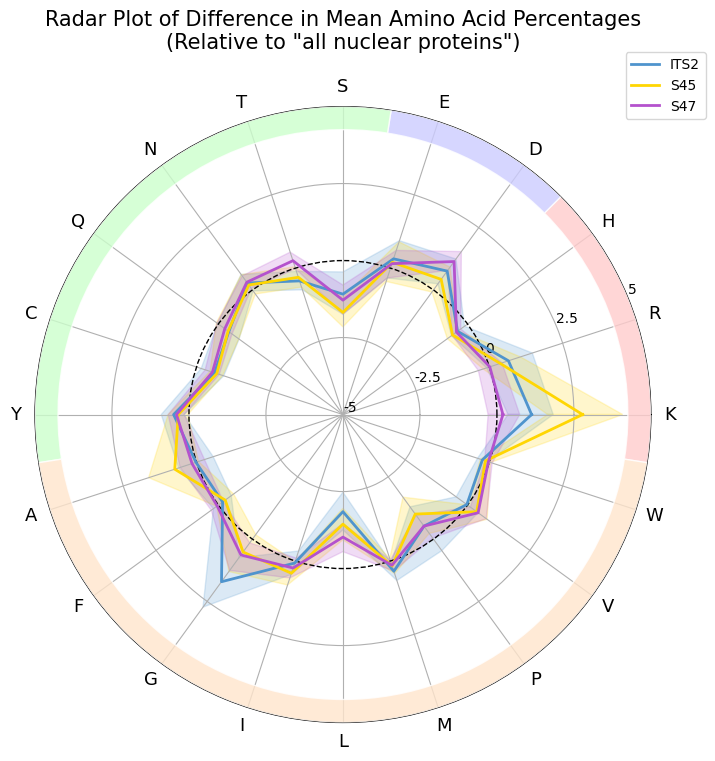

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

def bootstrap_diff_ci(data1, data2, n_bootstraps=10000, ci=95):

    diffs = []
    for _ in range(n_bootstraps):
        sample1 = np.random.choice(data1, size=len(data1), replace=True)
        sample2 = np.random.choice(data2, size=len(data2), replace=True)
        diffs.append(np.mean(sample1) - np.mean(sample2))
    lower = np.percentile(diffs, (100 - ci) / 2)
    upper = np.percentile(diffs, 100 - (100 - ci) / 2)
    return lower, upper

def plot_radar_plot_difference(df, n_bootstraps=1000, ci_level=95):

    df = df.copy()

    palette = {
        'S45': '#FFD602',
        'S47': '#B452CD',
        'ITS2': '#4F94CD',
        'All Nuclear Proteins': '#757575'
    }
    baseline_label = 'All Nuclear Proteins'
    
    groups_order = [
        ('Positive', list("KRH")),
        ('Negative', list("DE")),
        ('Polar',    list("STNQCY")),
        ('Not-polar', list("AFGILMPVW"))
    ]
    
    new_aa_list = []
    for group_name, aas in groups_order:
        new_aa_list.extend(aas)
    if len(new_aa_list) != 20:
        raise ValueError("Total number of amino acids is not 20. Check your groups_order definition.")
    
    for aa in new_aa_list:
        df[f"{aa}_percent"] = df['Sequence'].str.count(aa) / df['Sequence'].str.len() * 100
    percent_cols = [f"{aa}_percent" for aa in new_aa_list]
    
    groups = df.groupby('Label')
    group_stats = {}
    for label, group in groups:
        means = {}
        for col in percent_cols:
            means[col] = group[col].mean()
        group_stats[label] = means

    if baseline_label not in group_stats:
        raise ValueError(f"Baseline label '{baseline_label}' not found in data.")
    baseline_means = group_stats[baseline_label]
    diff_stats = {}
    for label, means in group_stats.items():
        diff_stats[label] = {}
        for aa in new_aa_list:
            col = f"{aa}_percent"
            diff_stats[label][col] = means[col] - baseline_means[col]

    ci_stats = {}
    for label in df['Label'].unique():
        if label == baseline_label:
            continue
        ci_stats[label] = {}
        group_data = df[df['Label'] == label]
        baseline_data = df[df['Label'] == baseline_label]
        for aa in new_aa_list:
            col = f"{aa}_percent"
            data1 = group_data[col].values
            data2 = baseline_data[col].values
            ci_stats[label][col] = bootstrap_diff_ci(data1, data2, n_bootstraps=n_bootstraps, ci=ci_level)
    
    N = len(new_aa_list)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], new_aa_list, fontsize=13)
    
    diff_values_all = []
    for label, diffs in diff_stats.items():
        if label == baseline_label:
            continue
        for aa in new_aa_list:
            diff_values_all.append(diffs[f"{aa}_percent"])
    if diff_values_all:
        diff_limit = max(abs(np.min(diff_values_all)), abs(np.max(diff_values_all))) * 1.5
        diff_limit = math.ceil(diff_limit)
    else:
        diff_limit = 1
    outer_ring_bottom = diff_limit * 0.85
    outer_ring_height = diff_limit * 0.15
    new_max = outer_ring_bottom + outer_ring_height
    plt.ylim(-diff_limit, new_max)
    
    for label, diffs in diff_stats.items():
        if label == baseline_label:
            continue
        diff_values = [diffs[f"{aa}_percent"] for aa in new_aa_list]
        diff_values += diff_values[:1]
        color = palette.get(label, '#333333')
        ax.plot(angles, diff_values, linewidth=2, linestyle='solid', label=label, color=color)
        
        ci_lower = [ci_stats[label][f"{aa}_percent"][0] for aa in new_aa_list]
        ci_upper = [ci_stats[label][f"{aa}_percent"][1] for aa in new_aa_list]

        ci_lower.append(ci_lower[0])
        ci_upper.append(ci_upper[0])
        
        theta_polygon = np.concatenate([angles, angles[::-1]])
        r_polygon = np.concatenate([ci_lower, ci_upper[::-1]])
        ax.fill(theta_polygon, r_polygon, color=color, alpha=0.2)
    
    rticks = np.linspace(-new_max, new_max, 5)
    rtick_labels = [f'{tick:.1f}'.rstrip('0').rstrip('.') for tick in rticks]
    ax.set_rticks(rticks)
    ax.set_yticklabels(rtick_labels)
    
    gridlines = ax.yaxis.get_gridlines()
    for tick, grid in zip(rticks, gridlines):
        if np.isclose(tick, 0):
            grid.set_linewidth(1)
            grid.set_linestyle('--')
            grid.set_color('black')
    
    group_colors = {
        'Positive': '#FFCCCC',
        'Negative': '#CCCCFF',
        'Polar':    '#CCFFCC',
        'Not-polar': '#FFE5CC'
    }
    total_aas = len(new_aa_list)
    cum_index = 0
    for group_name, aas in groups_order:
        group_len = len(aas)
        left_angle = ((cum_index - 0.5) / total_aas) * 2 * np.pi
        if left_angle < 0:
            left_angle += 2 * np.pi
        width = (group_len / total_aas) * 2 * np.pi
        ax.bar(left_angle, outer_ring_height, width=width, bottom=outer_ring_bottom,
               color=group_colors.get(group_name, '#999999'),
               edgecolor='white', alpha=0.8, zorder=10, align='edge')
        cum_index += group_len

    plt.title('Radar Plot of Difference in Mean Amino Acid Percentages\n(Relative to "all nuclear proteins")', 
              size=15, y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.savefig('results/revision_plots/HCRproxy_radar_plot_difference.svg', bbox_inches='tight')

    plt.show()

plot_radar_plot_difference(data_all_prots)

**Violin plot of pI, mass, and disorder**

S47 vs S45: p = 0.000
S47 vs ITS2: p = 0.000
S47 vs All Nuclear Proteins: p = 0.076
S45 vs ITS2: p = 0.246
S45 vs All Nuclear Proteins: p = 0.000
ITS2 vs All Nuclear Proteins: p = 0.000
Y-axis limits: 2.90 to 9.89


/tmp/ipykernel_2484452/481355360.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2484452/481355360.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


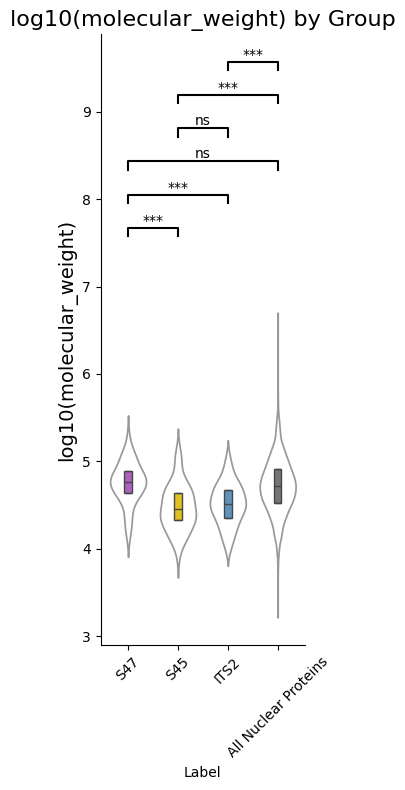

S47 vs S45: p = 0.000
S47 vs ITS2: p = 0.025
S47 vs All Nuclear Proteins: p = 0.000
S45 vs ITS2: p = 0.362
S45 vs All Nuclear Proteins: p = 0.083
ITS2 vs All Nuclear Proteins: p = 0.873
Y-axis limits: 1.88 to 18.16


/tmp/ipykernel_2484452/481355360.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2484452/481355360.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


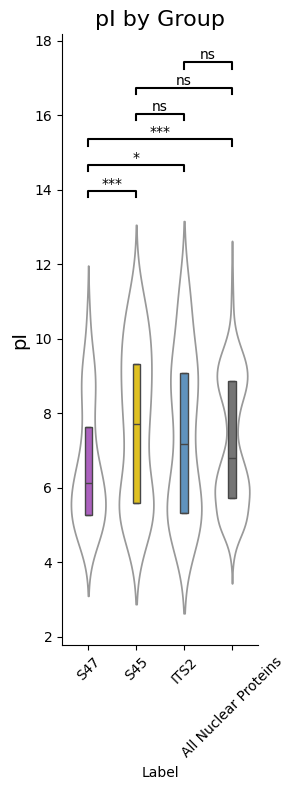

S47 vs S45: p = 0.316
S47 vs ITS2: p = 0.119
S47 vs All Nuclear Proteins: p = 0.030
S45 vs ITS2: p = 0.564
S45 vs All Nuclear Proteins: p = 0.772
ITS2 vs All Nuclear Proteins: p = 0.543
Y-axis limits: -0.27 to 1.53


/tmp/ipykernel_2484452/481355360.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2484452/481355360.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


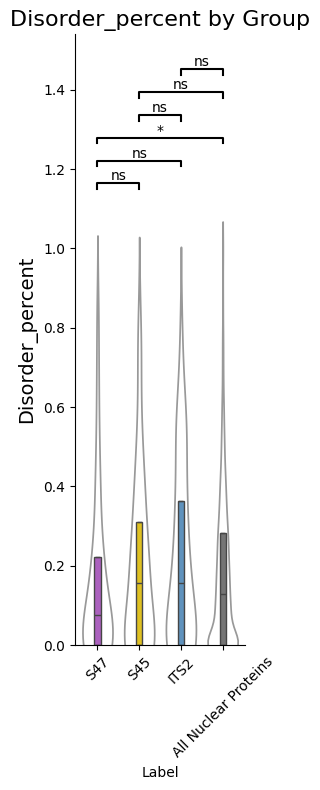

In [10]:
def plot_grouped_violin(df, group_col='group', value_col='value', log=False, test=None, order=None):
    assert test in ["ttest", "mannwhitneyu"], "test must be either 'ttest' or 'mannwhitneyu'"
    plot_df = df.copy()

    if log:
        plot_df[f"log10({value_col})"] = np.log10(plot_df[value_col] + 1)
        value_col = f"log10({value_col})"

    if order is None:
        order = list(plot_df[group_col].unique())

    comparisons = list(itertools.combinations(order, 2))

    results = []
    for group_a, group_b in comparisons:
        data_a = plot_df[plot_df[group_col] == group_a][value_col].dropna()
        data_b = plot_df[plot_df[group_col] == group_b][value_col].dropna()
        if test == "ttest":
            stat, p_val = ttest_ind(data_a, data_b, equal_var=False)
        elif test == "mannwhitneyu":
            stat, p_val = mannwhitneyu(data_a, data_b, alternative='two-sided')


        print(f'{group_a} vs {group_b}: p = {p_val:.3f}')
        results.append((group_a, group_b, p_val))

    hex_palette =   {
        'S45': '#FFD602',
        'S47': '#B452CD',
        'ITS2': '#4F94CD',
        'All Nuclear Proteins': '#757575'
        }
    
    white_palette = {key: '#FFFFFF' for key in hex_palette}

    plt.figure(figsize=(3, 8))

    sns.violinplot(
        x=group_col, y=value_col, data=plot_df, order=order,
        palette=white_palette, inner=None, gap=0.1, zorder=0
    )
    ax = sns.boxplot(
        x=group_col, y=value_col, data=plot_df, order=order,
        palette=hex_palette, showfliers=False,
        width=0.15, whis=0, zorder=2
    )

    y_max = plot_df[value_col].max() * 1.15
    y_step = y_max / 20

    tick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
    tick_map = {label: pos for label, pos in zip(tick_labels, ax.get_xticks())}

    for idx, (group_a, group_b, p_val) in enumerate(results):
        x1, x2 = tick_map[group_a], tick_map[group_b]
        y, h = y_max + idx * y_step, y_step / 4
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='black')
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
        ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color='black')

    plt.title(f'{value_col} by Group', fontsize=16)
    plt.ylabel(value_col, fontsize=14)
    plt.xticks(rotation=45)

    sns.despine()
    plt.tight_layout()

    y_min, y_max = ax.get_ylim()
    print(f"Y-axis limits: {y_min:.2f} to {y_max:.2f}")
    if value_col == "pI":
        plt.ylim(1.77, 18.17)
    if value_col == "Length":
        plt.ylim(0.91, 6.87)
    if value_col == "molecular_weight":
        plt.ylim(2.99,7.87)
    if value_col == "Disorder_percent":
        plt.ylim(0, 1.54)
    # plt.savefig(f'results/revision_plots/HCR_proxy_violin_{value_col}.svg')

    plt.show()

### limits of HCR-proxy data ###
# Y-axis limits: 1.77 to 18.17
# Y-axis limits: 0.91 to 6.87

from Bio.SeqUtils.ProtParam import ProteinAnalysis

aa_map = {
    'U': 'C',  # Selenocysteine → Cysteine
    'O': 'K',  # Pyrrolysine → Lysine
    'B': 'N',  # Aspartic acid/Asparagine (Asx) → Asparagine
    'Z': 'Q',  # Glutamic acid/Glutamine (Glx) → Glutamine
    'J': 'L',  # Leu/Ile ambiguity → Leucine
    'X': ''    # Unknown amino acid → removed
}

def clean_sequence(seq):
    seq = seq.upper()
    for old, new in aa_map.items():
        seq = seq.replace(old, new)
    return seq

def get_mw(seq):
    seq = clean_sequence(seq)
    if len(seq) == 0:
        return 0 
    return ProteinAnalysis(seq).molecular_weight()
order = ["S47", "S45", "ITS2", "All Nuclear Proteins"]

data_all_prots["molecular_weight"] = data_all_prots["Sequence"].apply(get_mw)
data_all_prots["pI"] = data_all_prots["Sequence"].apply(lambda x: IsoelectricPoint.IsoelectricPoint(x).pi())

plot_grouped_violin(data_all_prots, group_col='Label', value_col='molecular_weight', log=True, test="mannwhitneyu",order=order)
plot_grouped_violin(data_all_prots, group_col='Label', value_col='pI', log=False, test="mannwhitneyu",order=order)
plot_grouped_violin(data_all_prots, group_col='Label', value_col='Disorder_percent', log=False, test="mannwhitneyu",order=order)


**Plotting the difference in aminoacid usage with statistical evaluation of the difference in means between compartment and control**

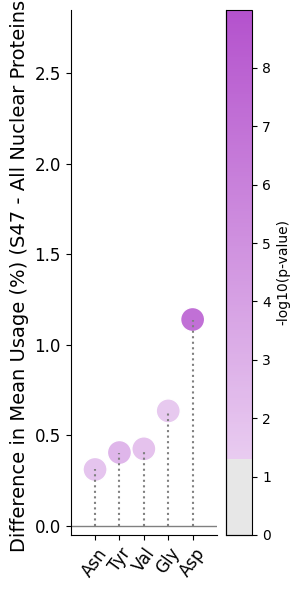

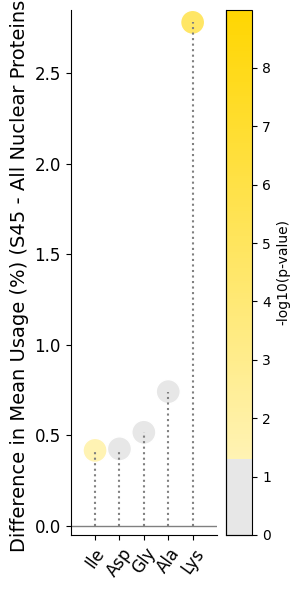

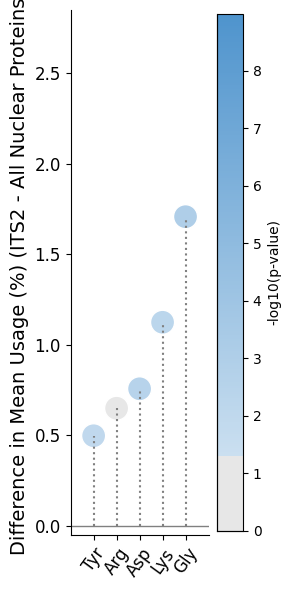

In [11]:
def plot_amino_acid_usage(df):

    amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
    
    records = []
    
    for idx, row in df.iterrows():
        seq = row['Sequence'].upper()
        seq_len = len(seq)
        
        if seq_len == 0:
            continue
        
        for aa in amino_acids:
            count = seq.count(aa)
            percentage = (count / seq_len) * 100
            records.append({
                'Protein_ID': row.get('Protein ID', None),
                'Label': row['Label'],
                'AminoAcid': aa,
                'Percentage': percentage
                
            })
    
    usage_df = pd.DataFrame(records)
    return usage_df

def create_cmap_with_greyed_non_sig(data_column, custom_color_hex=None, cmap_name=None, pvalue_cutoff=0.05, color_percent=0.7):

    assert custom_color_hex is not None or cmap_name is not None, "Provide either custom_color_hex or cmap_name"

    grey_cmap = LinearSegmentedColormap.from_list('grey_cmap', ['#E7E7E7', '#E7E7E7'], N=256)

    if custom_color_hex is not None:
        base_rgb = mcolors.to_rgb(custom_color_hex)
        near_white = tuple(base + (1.0 - base) * color_percent for base in base_rgb)
        custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [near_white, custom_color_hex], N=256)
    else:
        custom_cmap = plt.get_cmap(cmap_name)
    
    max_neg_log_p = data_column.max()
    max_neg_log_p = 8.991854
    min_neg_log_p = -np.log10(pvalue_cutoff)

    grey_span = int((256*min_neg_log_p) / max_neg_log_p) if max_neg_log_p != 0 else 256
    cool_span = int(256 - grey_span)

    colors = np.vstack((
        grey_cmap(np.linspace(0, 1, grey_span)),
        custom_cmap(np.linspace(0, 1, cool_span))
    ))

    cmap = LinearSegmentedColormap.from_list('combined_cmap', colors)
    return cmap

def plot_amino_acid_diff(usage_df, label1='S47', label2='S45', custom_color_hex=None):

    group_means = usage_df.groupby(['Label', 'AminoAcid'])['Percentage'].mean().reset_index()
    pivot_df = group_means.pivot(index='AminoAcid', columns='Label', values='Percentage')
    
    pivot_df['Diff'] = pivot_df[label1] - pivot_df[label2]
    

    ttest_results = []
    amino_acids = pivot_df.index.tolist()
    
    for aa in amino_acids:

        group1 = usage_df[(usage_df['AminoAcid'] == aa) & (usage_df['Label'] == label1)]['Percentage']
        group2 = usage_df[(usage_df['AminoAcid'] == aa) & (usage_df['Label'] == label2)]['Percentage']

        # u_stat, p_val = mannwhitneyu(group1, group2)
        t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
        ttest_results.append({'AminoAcid': aa, 'p_val': p_val})
    
    ttest_df = pd.DataFrame(ttest_results).set_index('AminoAcid')
    

    pivot_df = pivot_df.join(ttest_df)

    pivot_df['neg_log10_pval'] = -np.log10(pivot_df['p_val'].replace(0, 1e-300))
    

    pivot_df.sort_values('Diff', inplace=True)

    pivot_df = pivot_df.iloc[-5:]

    plt.figure(figsize=(3,6))
    
    positions = np.arange(len(pivot_df))
    
    aa_map = {
        'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp',
        'C': 'Cys', 'E': 'Glu', 'Q': 'Gln', 'G': 'Gly',
        'H': 'His', 'I': 'Ile', 'L': 'Leu', 'K': 'Lys',
        'M': 'Met', 'F': 'Phe', 'P': 'Pro', 'S': 'Ser',
        'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val'
    }
    
    aa_labels = [aa_map.get(aa, aa) for aa in pivot_df.index]

    if custom_color_hex is not None:
        cmap = create_cmap_with_greyed_non_sig(pivot_df['neg_log10_pval'], custom_color_hex=custom_color_hex)
    else:
        cmap = create_cmap_with_greyed_non_sig(pivot_df['neg_log10_pval'], cmap_name='Blues')
    
    scatter = plt.scatter(positions, pivot_df['Diff'], s=300, 
                          c=pivot_df['neg_log10_pval'], cmap=cmap, edgecolor='white', vmin=0, vmax=8.991854)
    
    for pos, diff in zip(positions, pivot_df['Diff']):
        plt.plot([pos, pos], [0, diff], linestyle=':', color='gray')
    
    plt.axhline(0, color='gray', linewidth=1)
    
    plt.xticks(positions, aa_labels, rotation=54, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('')
    plt.ylabel('Difference in Mean Usage (%) ({} - {})'.format(label1, label2), fontsize=14)
    
    cbar = plt.colorbar(scatter)
    cbar.set_label('-log10(p-value)')
    
    plt.tight_layout()
    sns.despine()
    plt.xlim(-1.0, len(pivot_df))

    plt.ylim(-0.05, 2.85)

    plt.savefig(f"results/revision_plots/HCRproxy_amino_acid_diff_{label1}_{label2}_in_Color.svg", bbox_inches='tight')

    plt.show()

usage_df = plot_amino_acid_usage(data_all_prots)

plot_amino_acid_diff(usage_df, label1='S47', label2='All Nuclear Proteins', custom_color_hex="#B452CD")
plot_amino_acid_diff(usage_df, label1='S45', label2='All Nuclear Proteins', custom_color_hex="#FFD602")
plot_amino_acid_diff(usage_df, label1='ITS2', label2='All Nuclear Proteins', custom_color_hex="#4F94CD")

**Plotting the number of RRM domains in each compartment**

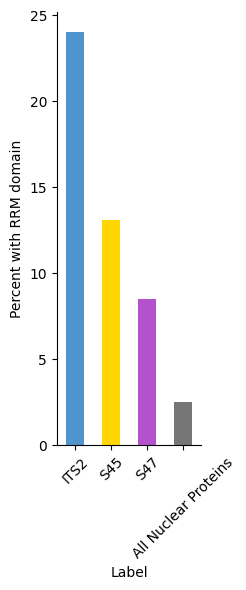

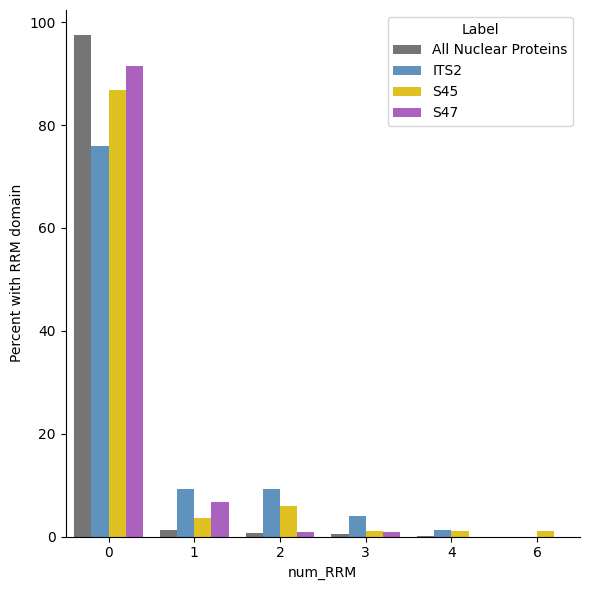

In [12]:
hex_palette =   {
    'S45': '#FFD602',
    'S47': '#B452CD',
    'ITS2': '#4F94CD',
    'All Nuclear Proteins': '#757575'
    }

data_all_prots["has_RRM"] = data_all_prots["Parsed_Domains"].apply(lambda x: "RRM" in str(x))
data_all_prots["num_RRM"] = data_all_prots["Parsed_Domains"].apply(lambda x: str(x).count("RRM"))
data_all_prots["has_disorder"] = data_all_prots["Disorder_percent"] > 0.0
data_all_prots

rrm_percent = data_all_prots.groupby('Label')['has_RRM'].mean() * 100
rrm_percent = rrm_percent.sort_values(ascending=False)
plt.figure(figsize=(2.5, 6))
rrm_percent.plot(kind='bar', color=[hex_palette[label] for label in rrm_percent.index])
plt.ylabel('Percent with RRM domain')
plt.xticks(rotation=45)
plt.tight_layout()
sns.despine()
plt.savefig('results/revision_plots/HCRproxy_percent_with_RRM.svg')
plt.show()

counts = data_all_prots.groupby(['Label', 'num_RRM']).size().reset_index(name='count')
total_counts = counts.groupby('Label')['count'].transform('sum')
counts['percent'] = counts['count'] / total_counts * 100
plt.figure(figsize=(6, 6))
sns.barplot(
    data=counts,
    x="num_RRM",
    y="percent",
    hue="Label",
    palette=hex_palette
)
plt.xlabel("num_RRM")
plt.ylabel("Percent with RRM domain")
sns.despine()
plt.tight_layout()
plt.savefig('results/revision_plots/HCRproxy_num_RRM_distribution.svg')
plt.show()